In [1]:


import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt




In [47]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

In [3]:

# Import data into tensorflow dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)



Found 2152 files belonging to 3 classes.


In [4]:


class_names = dataset.class_names
class_names



['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 2 0 0 0 0 1 1 0]


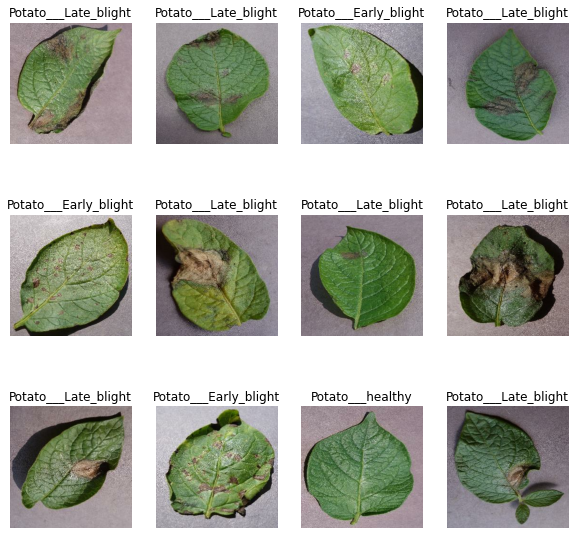

In [7]:
# Visualize some of the images from our dataset

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")



In [8]:
len(dataset)

68

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [23]:
# Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
# Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [25]:
# Data Augmentation
# Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [29]:
# Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
54/54 [==============================] - 112s 2s/step - loss: 0.9230 - accuracy: 0.4745 - val_loss: 0.8714 - val_accuracy: 0.6875
Epoch 2/5
54/54 [==============================] - 99s 2s/step - loss: 0.7287 - accuracy: 0.6863 - val_loss: 0.4994 - val_accuracy: 0.7812
Epoch 3/5
54/54 [==============================] - 98s 2s/step - loss: 0.4834 - accuracy: 0.8032 - val_loss: 0.3874 - val_accuracy: 0.8281
Epoch 4/5
54/54 [==============================] - 97s 2s/step - loss: 0.3337 - accuracy: 0.8692 - val_loss: 0.2586 - val_accuracy: 0.9010
Epoch 5/5
54/54 [==============================] - 106s 2s/step - loss: 0.3113 - accuracy: 0.8704 - val_loss: 0.2248 - val_accuracy: 0.9167


In [31]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 348ms/step - loss: 0.2616 - accuracy: 0.8945


In [32]:
scores

[0.2616366147994995, 0.89453125]

In [33]:
history

In [34]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
type(history.history['loss'])

list

In [37]:
len(history.history['loss'])

5

In [38]:
history.history['loss'][:5]

[0.9230313301086426,
 0.728727400302887,
 0.4834137260913849,
 0.3337197005748749,
 0.31131088733673096]

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [48]:
print(len(acc), len(val_acc), len(loss), len(val_loss))
print("Number of epochs:", EPOCHS)


5 5 5 5
Number of epochs: 5


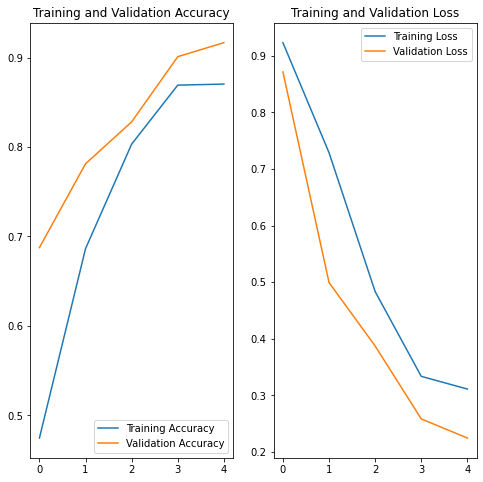

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 636ms/step
predicted label: Potato___Late_blight


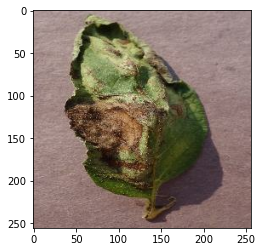

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [1]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

NameError: name 'plt' is not defined

In [44]:
import os
os.makedirs("C:/Users/SHIVANSHU/Desktop/project final/model0")

In [45]:
model_version=max([int(i) for i in os.listdir("C:/Users/SHIVANSHU/Desktop/project final/model0") + [0]])+1
model.save(f"C:/Users/SHIVANSHU/Desktop/project final/model0/{model_version}")

INFO:tensorflow:Assets written to: C:/Users/SHIVANSHU/Desktop/project final/model0/1\assets


INFO:tensorflow:Assets written to: C:/Users/SHIVANSHU/Desktop/project final/model0/1\assets


In [40]:
import os 

In [42]:
os.makedirs("C:/Users/SHIVANSHU/Desktop/project final/models")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:/Users/SHIVANSHU/Desktop/project final/models'

In [43]:
model_version=max([int(i) for i in os.listdir("C:/Users/SHIVANSHU/Desktop/project final/models") + [0]])+1
model.save(f"C:/Users/SHIVANSHU/Desktop/project final/models/{model_version}")

ValueError: invalid literal for int() with base 10: 'project.h5'

In [49]:
model.save("C:/Users/SHIVANSHU/Desktop/project final/models/project.h5")

In [58]:
import pickle
# open a file, where you ant to store the data
file = open('project0.pkl', 'wb')

# dump information to that file
pickle.dump(model, file)

In [60]:
file  = open('project0.pkl', 'rb')
model = pickle.load(file)

In [66]:
import tensorflow as tf
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

with open('tflite_model.tflite','wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\SHIVAN~1\AppData\Local\Temp\tmpzyhle48d\assets


INFO:tensorflow:Assets written to: C:\Users\SHIVAN~1\AppData\Local\Temp\tmpzyhle48d\assets


In [67]:
os.listdir(r"C:\Users\SHIVANSHU\Desktop\project final")

['.ipynb_checkpoints',
 'model0',
 'models',
 'PlantVillage',
 'Plant_Disease_Prediction.ipynb',
 'project0.pkl',
 'saved_models',
 'tflite_model.tflite']

In [43]:
import os

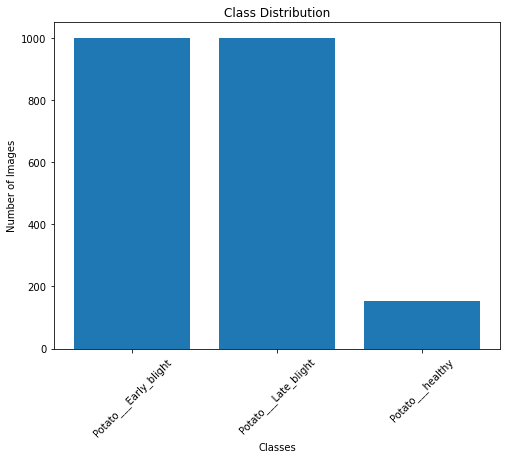

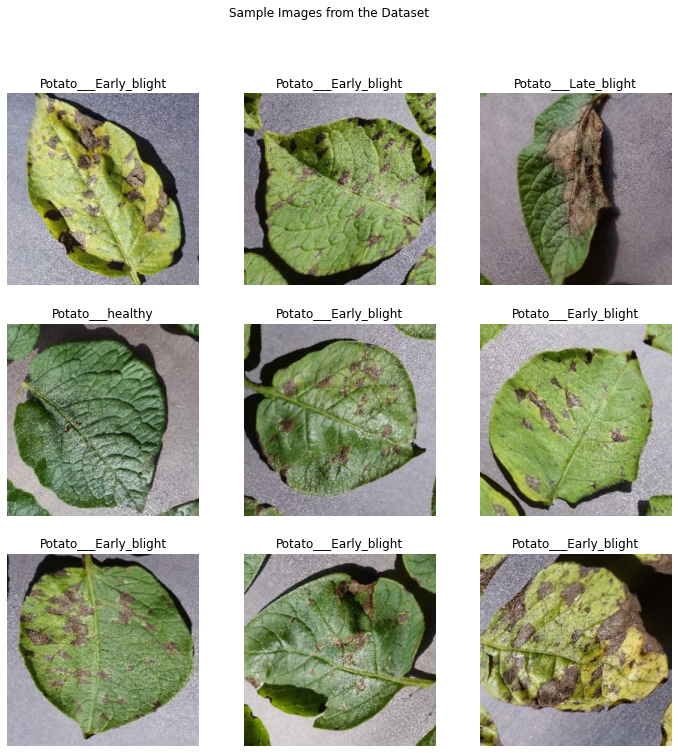

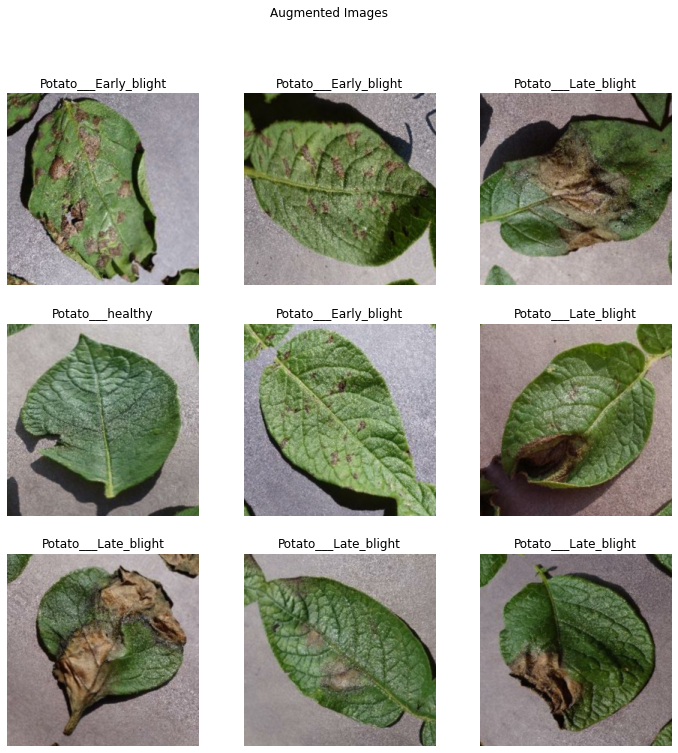

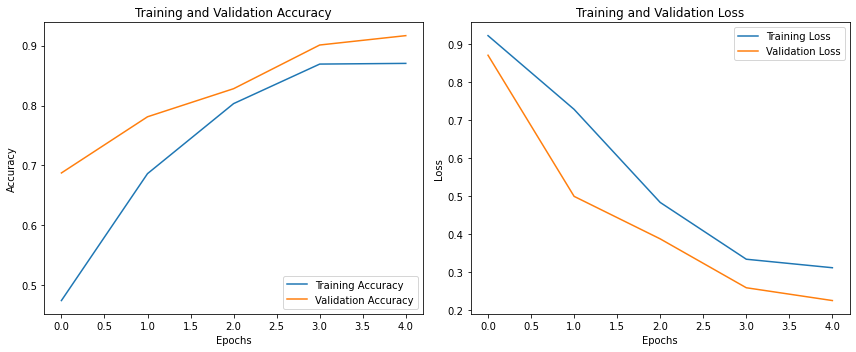

In [50]:
# ... (previous code remains unchanged)

# Plotting the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_names, [len(os.listdir(os.path.join("PlantVillage", class_name))) for class_name in class_names])
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Visualizing sample images from the dataset
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle('Sample Images from the Dataset')
plt.show()

# Displaying a sample of augmented images
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle('Augmented Images')
plt.show()

# Plotting training and validation accuracy/loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()
